In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft

In [12]:
df = 9.70127682e-04
f_nyquist = 800.1953125

def sinc(x):
    """Sinc function."""
    return np.sin(x) / x

def gaussian(mu, sig):
    x = np.linspace(0, 1, 1024)
    return np.exp(-0.5 * ((x - mu) / sig) ** 2) / (sig * np.sqrt(2 * np.pi))

prof = gaussian(0.5, 0.02)
prof_fft = rfft(prof)[1:]
powers = np.abs(prof_fft) ** 2.0
max_power = powers.sum()
prof_fft /= np.sqrt(max_power)

In [73]:
def harmonics(prof_fft, f_true, n_harm, N=4):
        """
        This function calculates the array of frequency-domain harmonics for a given
        pulse profile.

        Inputs:
        _______
                prof_fft (ndarray): FFT of pulse profile, not including zeroth harmonic
                df (float)        : frequency bin width in target spectrum
                n_harm (int)      : the number of harmonics before the Nyquist frequency
                N (int)           : number of bins over which to sinc-interpolate the harmonic
        Returns:
        ________
                bins (ndarray) : frequency bins of the injection
                harmonics (ndarray) : Fourier-transformed harmonics of the profile convolved with
                                        [cycles] number of Delta functions
        """
        # Because of the rapid drop-off of the sinc function, adding further interpolation bins gives a negligible increase
        # in power fidelity. Hence the default is 4.
        harmonics = np.zeros(N * n_harm)
        bins = np.zeros(N * n_harm).astype(int)

        # now evaluate sinc-modified power at each of the first 10 harmonics
        for i in range(n_harm):
            f_harm = (i + 1) * f_true
            bin_true = f_harm / df
            bin_below = np.floor(bin_true)
            bin_above = np.ceil(bin_true)

            # use 2 bins on either side
            current_bins = np.array(
                [bin_below - 1, bin_below, bin_above, bin_above + 1]
            )
            bins[i * N : (i + 1) * N] = current_bins
            
            amplitude = prof_fft[i] * sinc(np.pi * (bin_true - current_bins))

            harmonics[i * N : (i + 1) * N] = np.abs(amplitude) ** 2

        return bins, harmonics

In [74]:
n = 1000
scalloped_power = np.zeros(n)
f_true = np.linspace(50, 50.002, n)

for i in range(len(f_true)):

    n_harm = int(np.floor(f_nyquist / f_true[i]))

    if n_harm > 32:
        n_harm = 32

    bins, harms = harmonics(prof_fft, f_true[i], n_harm)
    scalloped_power[i] = harms.sum()

Text(0.5, 1.0, 'Effect of Scalloping on Pulses with 16 Harmonics')

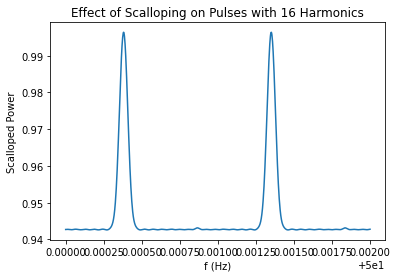

In [76]:
plt.plot(f_true, scalloped_power)
plt.xlabel('f (Hz)')
plt.ylabel('Scalloped Power')
plt.title('Effect of Scalloping on Pulses with 16 Harmonics')